In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
from itertools import chain

from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, ModelCheckpoint, History 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import itertools
import warnings
warnings.filterwarnings("ignore")

from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(2)

%matplotlib inline

Using TensorFlow backend.


<div class="theme"> Overview </div> 

### Galaxy Zoo
For this homework you will work with real astronomical data with the purpose of classifying galaxies based on visual attributes as they appear in astronomical surveys of the night sky, such as color and morphology. Galaxy morphology is strongly correlated with many physical parameters of those astronomical bodies, including their mass, density distribution, temperature, and star formation history. In turn, these parameters can be estimated using observations of the attributes mentioned above. 

The Galaxy Zoo project includes collected morphological attributes of nearly 900,000 galaxies drawn from the [Sloan Digital Sky Survey](http://skyserver.sdss.org/dr15/en/home.aspx). The annotation was provided by hundreds of thousands of volunteers, or 'citizen scientists' as we call them, who voted on the galaxy type based only on its image (for more details on galaxy morphology and classification see <a href="https://academic.oup.com/mnras/article/410/1/166/1032478">Chris Lintott et al.</a>). 

Your task is to train a binary classifier on the Galaxy Zoo data in order to distinguish an elliptical galaxy from spirals, mergers and unknown, which we will call non-elliptical galaxies, based on its visual morphology.  

We provide a subset of data in `galaxy_morphology_labeled.csv` so there is no need for you to download it. The full dataset is available at http://data.galaxyzoo.org.


<span class='sub-q'> Dataset Attributes:</span>
- **green_color**: the amount of light measured in the green frequency band (wavelength range 464 $\pm$ 128~nm)
- **red_color**: the amount of light measured in the red frequency band (wavelength range 658 $\pm$ 138~nm)
- **infrared_color**: the amount of light measured in the infrared frequency band (wavelength range 806 $\pm$ 149~nm)
- **de_vaucouleurs_fit_axial_ratio**: axial ratio associated with the [de Vaucouleurs fit](https://en.wikipedia.org/wiki/De_Vaucouleurs%27_law) to the two-dimensional image of the galaxy
- **exponential_fit_axial_ratio**: the axial ratio associated with an exponential fit to the two-D image of the galaxy 
- **exponential_disc_fit_log_likelihood**: log likelihood associated with an exponential fit to the two-D image of the galaxy
- **de_vaucouleurs_fit_log_likelihood**: log likelihood associated with a de Vaucouleurs fit to the two-D image of the galaxy
- **star_log_likelihood**: the log likelihood that the object is a point-like source (star) object rather than a galaxy
- **number_of_votes**: total number of volunteer votes
- **probability_elliptical**: fraction of votes for elliptical morphology
- **probability_spiral**: fraction of votes for spiral morphology
- **probability_unknown**: fraction of votes for unknown morphology
- **probability_merger**: fraction of votes for merger morphology
- **class**: morphology with the highest fraction of votes

Notice that the volunteers did not have access to any of the attributes but the galaxy shape when voting.

<div class='exercise'><b> Question 1: Models for Galaxy Classification </b></div>

In [3]:
galaxy_df = pd.read_csv('data/galaxy_morphology_labeled.csv')

galaxy_df['elliptical'] = 0
galaxy_df.loc[galaxy_df['class'] == 'elliptical','elliptical'] = 1
galaxy_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class,elliptical
0,17.952690,17.077210,16.696932,0.652044,0.674899,-299.83917,-147.78073,-2480.1614,30,0.033,0.933,0.033,0.000,spiral,0
1,15.870294,15.128039,14.746254,0.661844,0.631145,-4980.44200,-2094.24630,-41855.1640,58,0.000,1.000,0.000,0.000,spiral,0
2,16.473410,15.633129,15.174894,0.324888,0.356353,-3732.98900,-946.47595,-26244.6110,43,0.186,0.744,0.070,0.000,spiral,0
3,17.137112,16.744455,16.542747,0.582045,0.656639,-33.33683,-587.22380,-4487.7620,63,0.143,0.810,0.048,0.000,spiral,0
4,17.995703,17.621641,17.377476,0.449918,0.462352,-26.84463,-130.57242,-2392.1540,42,0.167,0.738,0.071,0.024,spiral,0


<span class='sub-q'> **1.1** Understanding the Problem.</span> It is a good practice to start by familiarizing yourself with the problem in hand. Read the atricle by [Manda Banerji et al.](https://academic.oup.com/mnras/article/406/1/342/1073212) and familiarize yourself with the attributes in the dataset and their descriptions. Based on your reading, which attributes in the data are most predictive of whether or not a galaxy is elliptical?


As we see in the paper, different parameters allow us to distinguish between different morphological classes. 

- Elliptical galaxies are found to be redder than spirals whereas the non-elliptical have a wide range of colours. 

- The axial ratio obtained from a de Vaucouleurs fit to the galaxy images is closer to unity for elliptical systems (typically **∼0.8**) compared to spirals (typically **∼0.3**) and has a bimodal distribution for the rest. 

- The log likelihood associated with the de Vaucouleurs fit is also **larger** for the ellipticals than the spirals and largest for the point sources and artefacts.

So the attributes in the data that are most predictive of whether or not a galaxy is elliptical, according to the paper, are: 1) color, 2) de_vaucouleurs_fit_axial_ratio, 3) de_vaucouleurs_fit_log_likelihood.

We consider the fractional vote threshold to be 0.8 for the galaxy belonging to a particular morphological class.

<span class='sub-q'> 1.2 Performing Data Exploration and Cleaning.</span> 



**1.2.1** The color bands sometimes include values that are far away from the rest, what we call outliers. Outlier values might indicate bad measurements for example instrumental failures. Remove the data points with these values in the color band of your choice. 


In [4]:
galaxy_df[['green_color', 'red_color', 'infrared_color']].describe()

,green_color,red_color,infrared_color
count,20170.000000,20170.000000,20170.000000
mean,17.070687,16.440295,16.130761
std,1.165214,1.249285,1.319114
min,7.238786,7.619027,7.231207
25%,16.550340,15.859993,15.510974
50%,17.319927,16.623186,16.270693
75%,17.833663,17.214431,16.903603
max,20.116318,27.952972,28.606903


In [5]:
## custom visualization functions
def box_plots(data, colors, labels, ax):
    bplot = ax.boxplot(data, patch_artist=True, labels=labels)
    objects_pairs = ['whiskers', 'caps']
    objects_single = ['boxes', 'fliers', 'means', 'medians']

    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.5)
        
    for obj in objects_single:
        for patch, color in zip(bplot[obj], colors):
            if obj == 'fliers':
                plt.setp(patch, marker='.', markerfacecolor=color, markersize=6, 
                         linestyle='none', markeredgecolor='None', alpha=0.1)
            elif obj == 'boxes':
                plt.setp(patch, facecolor=color, edgecolor=color, alpha=0.3)
            else:
                plt.setp(patch, color=color)
                patch.set_alpha(0.6)
        
    color_pairs = []
    for color in colors:
        color_pairs += [color] * 2
        
    for obj in objects_pairs:
        for patch, color in zip(bplot[obj], color_pairs):
            plt.setp(patch, color=color)
            patch.set_alpha(0.5)
            
    return ax

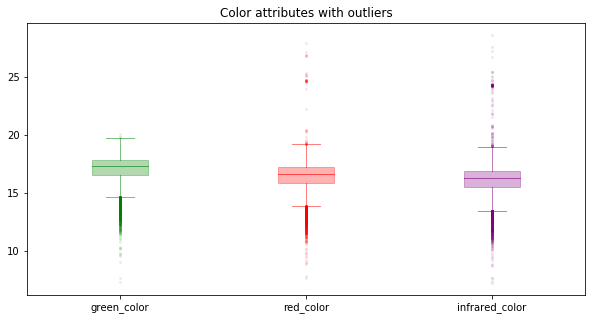

In [6]:
## boxplot with the outliers
colors = ['green', 'red', 'purple']
labels = galaxy_df.iloc[:, :3].columns
data = [galaxy_df[label] for label in labels]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = box_plots(data, colors, labels, ax)
ax.set_title('Color attributes with outliers')
plt.show()

In [7]:
galaxy_df = galaxy_df[
    (galaxy_df.green_color > (galaxy_df.green_color.mean() - 3*galaxy_df.green_color.std())) &\
    (galaxy_df.green_color < (galaxy_df.green_color.mean() + 3*galaxy_df.green_color.std())) &\
    (galaxy_df.red_color > (galaxy_df.red_color.mean() - 3*galaxy_df.red_color.std())) &\
    (galaxy_df.red_color < (galaxy_df.red_color.mean() + 3*galaxy_df.red_color.std())) &\
    (galaxy_df.infrared_color > (galaxy_df.infrared_color.mean() - 3*galaxy_df.infrared_color.std())) &\
    (galaxy_df.infrared_color < (galaxy_df.infrared_color.mean() + 3*galaxy_df.infrared_color.std()))
]

In [8]:
galaxy_df[['green_color', 'red_color', 'infrared_color']].describe()

,green_color,red_color,infrared_color
count,19758.000000,19758.000000,19758.000000
mean,17.138073,16.494510,16.167276
std,1.031861,1.075607,1.094378
min,13.578050,12.705601,12.330190
25%,16.599809,15.900341,15.556443
50%,17.336455,16.640027,16.282736
75%,17.841311,17.219729,16.905370
max,19.861967,19.561089,20.053421


We decide to treat the observations outside 3 standard deviations as outliers, and drop them.

**1.2.2** Are the features sufficiently distinguishing for the classification task? Do elliptical galaxies differ enough in terms of these attributes from other types of objects in the sky? 

**Hint:** compare the distributions of features for elliptical galaxies with the feature distributions of other objects in the data set.

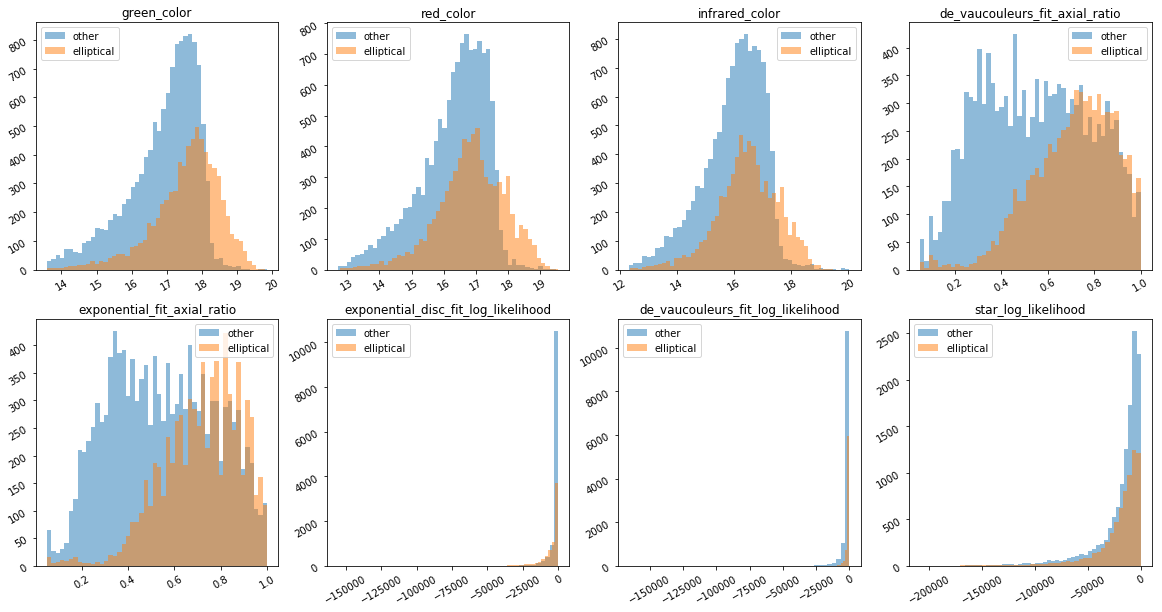

In [7]:
features = ["green_color", "red_color", "infrared_color", "de_vaucouleurs_fit_axial_ratio", \
            "exponential_fit_axial_ratio", "exponential_disc_fit_log_likelihood", \
            "de_vaucouleurs_fit_log_likelihood", "star_log_likelihood"]

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

for i in range(8):
    axs[i].hist(galaxy_df.loc[galaxy_df.elliptical == 0, features[i]], alpha=0.5, label='other', bins=50)
    axs[i].hist(galaxy_df.loc[galaxy_df.elliptical == 1, features[i]], alpha=0.5, label='elliptical', bins=50)
    axs[i].legend(loc='best')
    axs[i].set_title(str(features[i]))
    axs[i].tick_params(labelrotation=30)
    
plt.show()

Features 'exponential_disc_fit_log_likelihood' and 'de_vaucouleurs_fit_log_likelihood' distributions seem to be highly driven by the left tail, so we decide to trim the left tail and plot the distribution again.

In [8]:
galaxy_df_likelihood = galaxy_df[["exponential_disc_fit_log_likelihood", 
                                  "de_vaucouleurs_fit_log_likelihood",
                                  "elliptical"]]

galaxy_df_likelihood = galaxy_df_likelihood[
    (galaxy_df_likelihood.exponential_disc_fit_log_likelihood > (galaxy_df_likelihood.exponential_disc_fit_log_likelihood.mean() - 3*galaxy_df_likelihood.exponential_disc_fit_log_likelihood.std())) &\
    (galaxy_df_likelihood.de_vaucouleurs_fit_log_likelihood > (galaxy_df_likelihood.de_vaucouleurs_fit_log_likelihood.mean() - 3*galaxy_df_likelihood.de_vaucouleurs_fit_log_likelihood.std()))
]

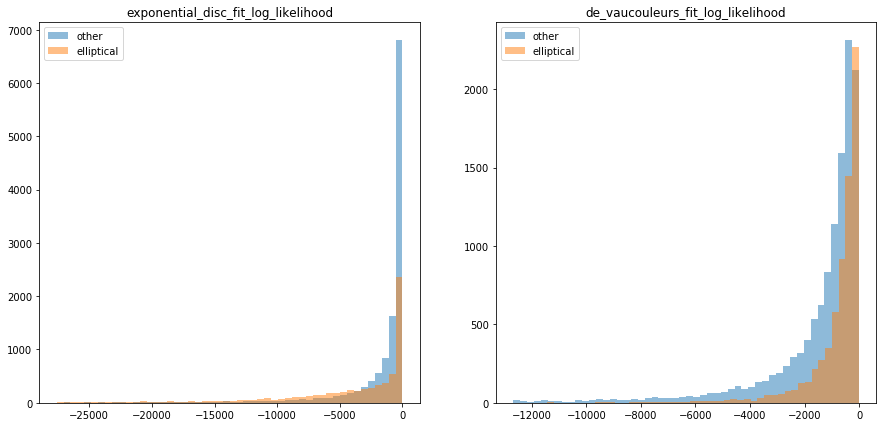

In [9]:
features_likelihood = ["exponential_disc_fit_log_likelihood", 
                       "de_vaucouleurs_fit_log_likelihood"]

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs = axs.ravel()

for i in range(2):
    axs[i].hist(galaxy_df_likelihood.loc[galaxy_df_likelihood.elliptical == 0, features_likelihood[i]], alpha=0.5, label='other', bins=50)
    axs[i].hist(galaxy_df_likelihood.loc[galaxy_df_likelihood.elliptical == 1, features_likelihood[i]], alpha=0.5, label='elliptical', bins=50)
    axs[i].legend(loc='best')
    axs[i].set_title(str(features_likelihood[i]))
    
plt.show()

Compare the distributions of features for elliptical galaxies with the feature distributions of other objects in the data set: 
- Color bands seem to have strong predictive power. Higher value of color, higher possbility of being elliptical.
- Two ratios seem to have strong predictive power. Higher value of ratio, higher possbility of being elliptical.
- Exponential_disc_fit_log_likelihood seems to have some weak predictive power. Elliptical may have some extremely negative values. 
- De_vaucouleurs_fit_log_likelihood seems to have some weak predictive power. Elliptical have values that are more concentrated to 0.
- star_log_likelihood doesn't seem to be predictive. 

<span class='sub-q'> 1.3 Feature Engineering. </span> The practice of creating new features by combining observed features in the data using domain knowledge is called *feature engineering*. Astronomers often use differences in color bands as an engineered feature that serves as a proxy to temperature. Create two new features in the data that represent temperature. Do these two new features help distinguish elliptical galaxies from other objects, i.e., are these two new features useful for the classification task?

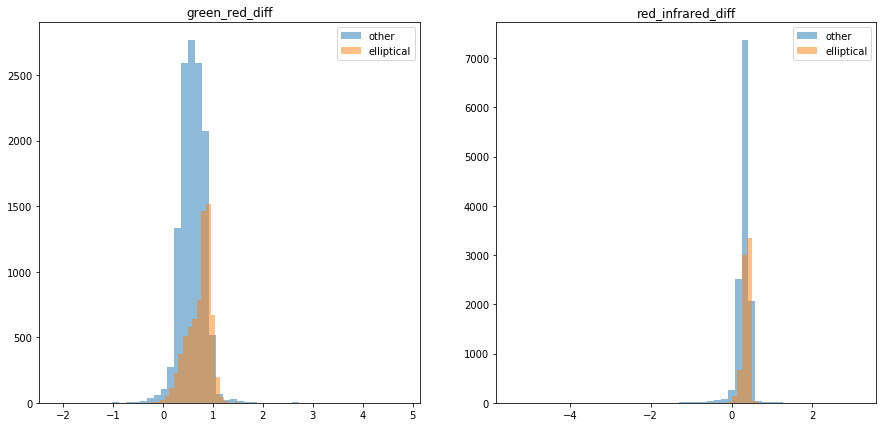

In [10]:
galaxy_df['green_red_diff'] = galaxy_df.green_color - galaxy_df.red_color
galaxy_df['red_infrared_diff'] = galaxy_df.red_color - galaxy_df.infrared_color

features = ["green_red_diff", "red_infrared_diff"]

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs = axs.ravel()

for i in range(2):
    axs[i].hist(galaxy_df.loc[galaxy_df.elliptical == 0, features[i]], alpha=0.5, label='other', bins=50)
    axs[i].hist(galaxy_df.loc[galaxy_df.elliptical == 1, features[i]], alpha=0.5, label='elliptical', bins=50)
    axs[i].legend(loc='upper right')
    axs[i].set_title(str(features[i]))

plt.show()

The two new features are also able to distinguish elliptical from other objects, so they should be useful for the classification.

<span class='sub-q'> 1.4 Training a Baseline Classifier. </span> Using `keras`, construct and train a MLP classifier to classify galaxies as either elliptical or non-elliptical based on your expanded set of features. 

For the network you want to consider:
- the number of hidden layers
- the number of nodes in each hidden layer
- the activation function (we suggest starting with `relu`)
- the choice of a loss function
- the choice of mini-batch size (we suggest between 1000 and 5000)
- the choice of an optimizer and its parameters, for example: `learning rate`, `momentum`, and `learning rate decay`
- the number of epochs

**Hint:** You can expect to achieve an average classification accuracy of >80% with the appropriate choices.

In [11]:
## Preprocessing the data
features = ["green_color", "red_color", "infrared_color", "de_vaucouleurs_fit_axial_ratio", 
            "exponential_fit_axial_ratio", "exponential_disc_fit_log_likelihood", 
            "de_vaucouleurs_fit_log_likelihood", "star_log_likelihood", "green_red_diff", "red_infrared_diff"]

x_train, x_test, y_train_raw, y_test_raw = train_test_split(galaxy_df[features], 
                                                            galaxy_df.elliptical, 
                                                            test_size=0.3,
                                                            stratify=galaxy_df.elliptical)

## Normalize the data
x_mean = x_train.mean()
x_std =  x_train.std()
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

y_train = np_utils.to_categorical(y_train_raw, 2)
y_test = np_utils.to_categorical(y_test_raw, 2)

In [12]:
## hyperparameters
epochs = 30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [13]:
## build the model
input_dim = x_train.shape[1]

model1 = Sequential()
model1.add(Dense(32, activation="relu", input_dim = input_dim)) 
model1.add(Dense(2, activation="sigmoid"))

## compile the model
model1.compile(loss='binary_crossentropy',
               optimizer=sgd,
               metrics=['acc'])

In [14]:
## fit the model
batch_size = int(x_train.shape[0]/100)

model1_history = model1.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=.2,
                            verbose=0)

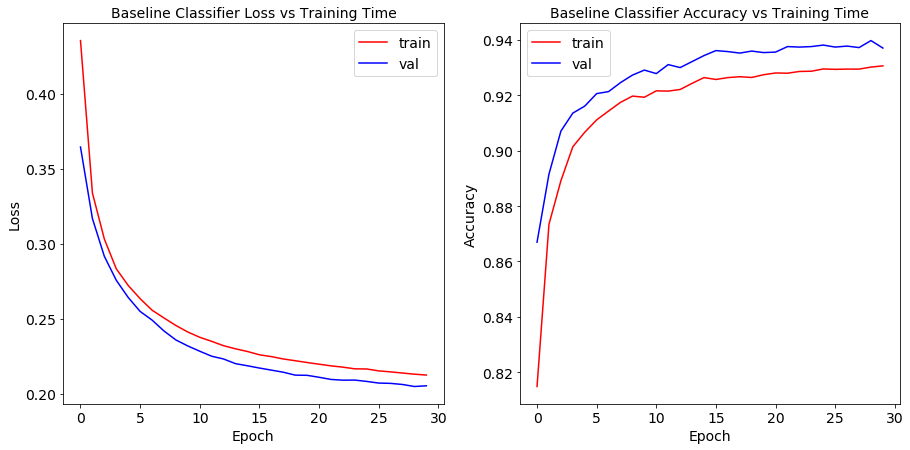

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(model1_history.history['loss'], 'r', label='train')
ax[0].plot(model1_history.history['val_loss'], 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].set_title(r'Baseline Classifier Loss vs Training Time', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(model1_history.history['acc'], 'r', label='train')
ax[1].plot(model1_history.history['val_acc'], 'b' ,label='val')
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].set_title(r'Baseline Classifier Accuracy vs Training Time', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

In [16]:
model_base_loss, model_base_acc = model1.evaluate(x_test, y_test)
print("Baseline model test set loss value: %.2f, accuracy: %.2f" % (model_base_loss, model_base_acc))

5928/5928 [==============================] - 0s 12us/step
Baseline model test set loss value: 0.22, accuracy: 0.93


<span class='sub-q'>1.5 Evaluating and Improving Your Classifier. </span> Choose an appropriate metric for evaluating your classifier. Is the average classification accuracy a good metric for this data given the distribution of the classes? Improve your classifier based on the distribution of the classes and on your evaluation of the baseline classifier. 

**Hint:** You can expect to achieve an average classification accuracy of >90% with this.

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          fontsize=16):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)

    plt.ylabel('True label', fontsize=fontsize)
    plt.xlabel('Predicted label', fontsize=fontsize)
    plt.tight_layout()

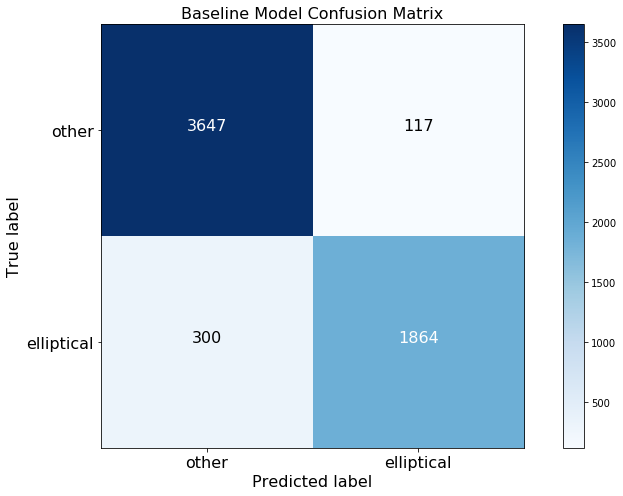

In [18]:
## Confusion matrix
y_pred = model1.predict(x_test)

cnf_matrix = confusion_matrix(y_test_raw, y_pred.argmax(axis=-1))

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["other", "elliptical"], normalize=False,
                      title='Baseline Model Confusion Matrix')

In [19]:
precision, recall, F1, _ = precision_recall_fscore_support(y_test_raw, y_pred.argmax(axis=-1), average='binary')

print("Base model precision: %.2f, recall: %.2f, F1: %.2f" % (precision, recall, F1))
print("Pecentage of elliptical in test data: %.2f%%" % (100 * y_test_raw.sum()/y_test_raw.count()))
print("Pecentage of elliptical classified correctly: %.2f%%" % (100 * cnf_matrix[1][1]/np.sum(cnf_matrix[1])))

Base model precision: 0.94, recall: 0.86, F1: 0.90
Pecentage of elliptical in test data: 36.50%
Pecentage of elliptical classified correctly: 86.14%


The input data is biased to the non elliptical calss which account to ~65% of the total data. If the model classifies everything to non elliptical, the average accuracy would be ~65%. For our baseline model, even though the average accuracy is about 93%, ~ 85% of the elliptical class classfied correctly given the data is biased. Therefore, using the average accracy itself is not a good metric. We should balance the recall and precision ratio, so we think using F1 in this case is better than average accuracy.

In [20]:
#### Improve the model

## hyperparameters
epochs=100
learning_rate = 0.75
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

## build the model
input_dim = x_train.shape[1]

model2 = Sequential()
model2.add(Dense(64, activation="relu", input_dim = input_dim)) 
model2.add(Dense(64,  activation="relu"))
model2.add(Dense(2,  activation="sigmoid"))

## compile the model
model2.compile(loss='binary_crossentropy',
               optimizer=sgd,
               metrics=['acc'])

## fit the model
batch_size = int(x_train.shape[0]/100)

model2_history = model2.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=.3,
                            verbose=0)

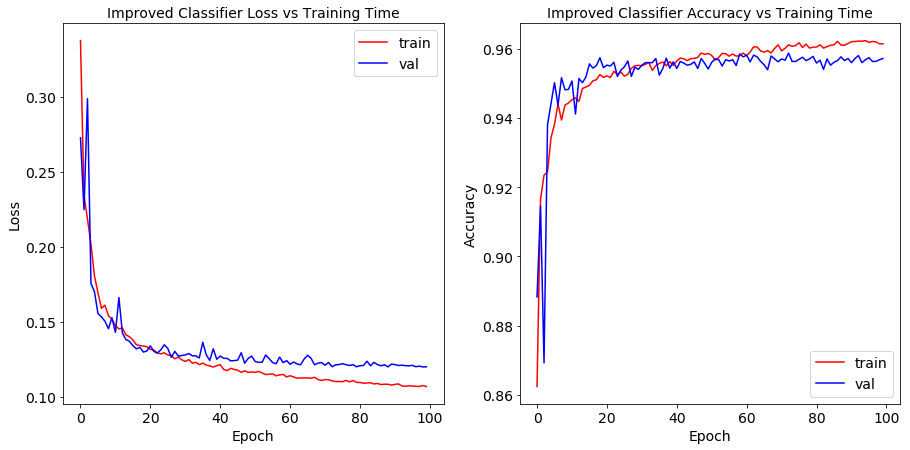

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].plot(model2_history.history['loss'], 'r', label='train')
ax[0].plot(model2_history.history['val_loss'], 'b' ,label='val')
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].set_title(r'Improved Classifier Loss vs Training Time', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(model2_history.history['acc'], 'r', label='train')
ax[1].plot(model2_history.history['val_acc'], 'b' ,label='val')
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].set_title(r'Improved Classifier Accuracy vs Training Time', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

In [22]:
model_base_loss, model_base_acc = model2.evaluate(x_test, y_test)
print("Improved model test set loss value: %.2f, accuracy: %.2f" % (model_base_loss, model_base_acc))

5928/5928 [==============================] - 0s 13us/step
Improved model test set loss value: 0.13, accuracy: 0.95


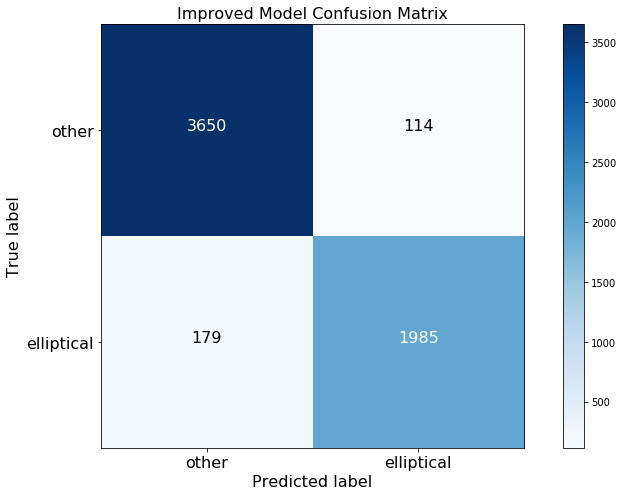

In [23]:
y_pred = model2.predict(x_test, batch_size=batch_size)

cnf_matrix = confusion_matrix(y_test_raw, y_pred.argmax(axis=-1))

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["other", "elliptical"], normalize=False,
                      title='Improved Model Confusion Matrix')

In [24]:
precision, recall, F1, _ = precision_recall_fscore_support(y_test_raw, y_pred.argmax(axis=-1), average='binary')

print("Improved model precision: %.2f, recall: %.2f, F1: %.2f" % (precision, recall, F1))
print("Pecentage of elliptical in test data: %.2f%%" % (100 * y_test_raw.sum()/y_test_raw.count()))
print("Pecentage of elliptical classified correctly: %.2f%%" % (100 * cnf_matrix[1][1]/np.sum(cnf_matrix[1])))

Improved model precision: 0.95, recall: 0.92, F1: 0.93
Pecentage of elliptical in test data: 36.50%
Pecentage of elliptical classified correctly: 91.73%


We have improved the classifier by the following steps:
1. add one more hidden layer
2. increase the nodes to 64
3. lower the learning rate
4. increase the number of epochs

We have improved the average classification accuracy from 93% to 95%, the pecentage of elliptical classified correctlhy from 86% to 92%, and F1 score from 89% to 93%.

<div class='exercise'><b> Question 2: Optimization Problems in Model Training </b></div>

In Question 1, you found an appropriate choice of training parameters for your model (e.g. optimizer, learning rate etc). In this problem, you will carefully investigate the effect of these parameters on the baseline model from Question 1.


<span class='sub-q'> 2.1 </span> Using the Adam optimizer, plot the loss function as well as the average classification accuracy [PP: training accuracies] for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set.


In [25]:
## hyperparameters
epochs = 200

## Learning rates
learning_rate_list = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]

## results
adam_results = []

for learning_rate in learning_rate_list: 
    ## decay rate
    decay_rate = learning_rate / epochs

    ## optimizer 
    adam = Adam(lr=learning_rate, decay=decay_rate)

    ## build the model
    input_dim = x_train.shape[1]

    lr_model = Sequential()
    lr_model.add(Dense(32, activation="relu", input_dim = input_dim)) 
    lr_model.add(Dense(2, activation="sigmoid"))

    ## compile the model
    lr_model.compile(loss='binary_crossentropy',
                     optimizer=adam,
                     metrics=['acc'])

    ## fit the model
    batch_size = int(x_train.shape[0]/100)

    lr_model_history = lr_model.fit(x_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_split=.2,
                                    verbose=0)
    
    adam_results.append(lr_model_history)

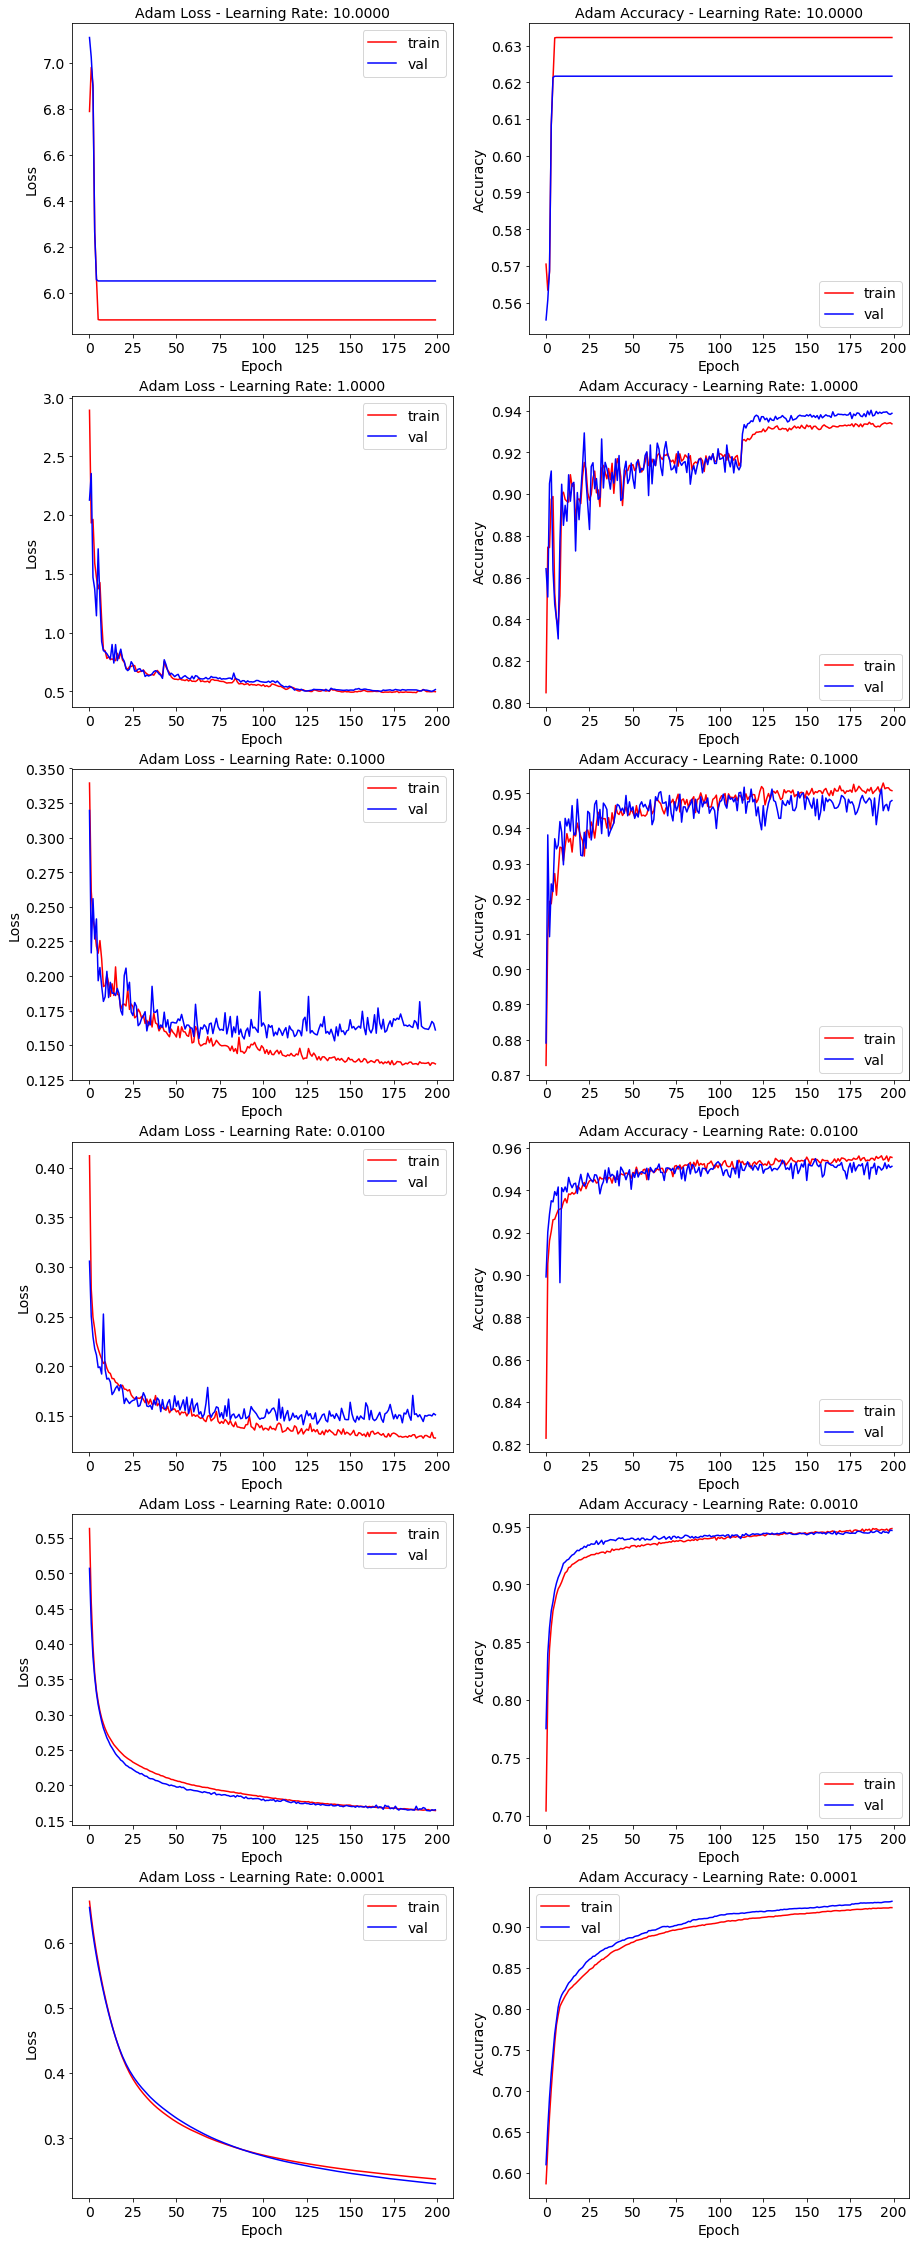

In [26]:
fig, ax = plt.subplots(len(learning_rate_list), 2, figsize=(15, 40))

for i in range(len(learning_rate_list)):
    ax[i][0].plot(adam_results[i].history['loss'], 'r', label='train')
    ax[i][0].plot(adam_results[i].history['val_loss'], 'b', label='val')
    ax[i][0].set_xlabel(r'Epoch', fontsize=14)
    ax[i][0].set_ylabel(r'Loss', fontsize=14)
    ax[i][0].set_title(r'Adam Loss - Learning Rate: %.4f' % learning_rate_list[i], fontsize=14)
    ax[i][0].legend(fontsize=14)
    ax[i][0].tick_params(labelsize=14)

    ax[i][1].plot(adam_results[i].history['acc'], 'r', label='train')
    ax[i][1].plot(adam_results[i].history['val_acc'], 'b' ,label='val')
    ax[i][1].set_xlabel(r'Epoch', fontsize=14)
    ax[i][1].set_ylabel(r'Accuracy', fontsize=14)
    ax[i][1].set_title(r'Adam Accuracy - Learning Rate: %.4f' % learning_rate_list[i], fontsize=14)
    ax[i][1].legend(fontsize=14)
    ax[i][1].tick_params(labelsize=14)


In [27]:
## Compare learning rates
adam_loss_df = pd.DataFrame()
adam_acc_df = pd.DataFrame()

for i in range(len(learning_rate_list)):
    adam_loss_df[str(learning_rate_list[i])] = list(adam_results[i].history['val_loss'])
    adam_acc_df[str(learning_rate_list[i])] = list(adam_results[i].history['val_acc'])

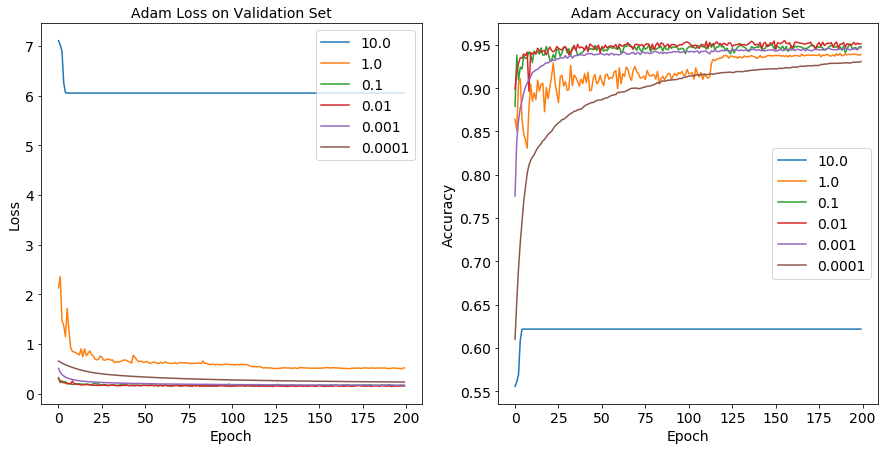

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

adam_loss_df.plot(ax=ax[0])
ax[0].set_title(r'Adam Loss on Validation Set', fontsize=14)
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].legend(fontsize=14, loc='upper right')
ax[0].tick_params(labelsize=14)

adam_acc_df.plot(ax=ax[1])
ax[1].set_title(r'Adam Accuracy on Validation Set', fontsize=14)
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].legend(fontsize=14, loc='best')
ax[1].tick_params(labelsize=14)

In [29]:
adam_opt_lr = float(list(adam_acc_df.idxmax(axis=1))[-1])
print("Learning rate of %.2f gives the highest accuracy for Adam optimizer." % adam_opt_lr)

Learning rate of 0.01 gives the highest accuracy for Adam optimizer.


<span class='sub-q'> 2.2 </span> Using the SGD optimizer, plot the loss function as well as the average classification accuracy for each of the following learning rates `[1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]`. Compare these graphs and make an argument for which of these learning rates is more appropriate for our data set. For the optimal learning rate, experiment with a range of values for momentum, `[9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]` with a learning rate decay of `optimal_rate / total_epochs`. Make an argument for which value of momentum is more appropriate for our data set.


In [30]:
## hyperparameters
epochs = 200
momentum = 0.8

## Learning rates
learning_rate_list = [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]

## results
sgd_results = []

for learning_rate in learning_rate_list: 
    ## decay rate
    decay_rate = learning_rate / epochs

    ## optimizer 
    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

    ## build the model
    input_dim = x_train.shape[1]

    lr_model = Sequential()
    lr_model.add(Dense(32, activation="relu", input_dim = input_dim)) 
    lr_model.add(Dense(2, activation="sigmoid"))

    ## compile the model
    lr_model.compile(loss='binary_crossentropy',
                     optimizer=sgd,
                     metrics=['acc'])

    ## fit the model
    batch_size = int(x_train.shape[0]/100)

    lr_model_history = lr_model.fit(x_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_split=.2,
                                    verbose=0)
    
    sgd_results.append(lr_model_history)

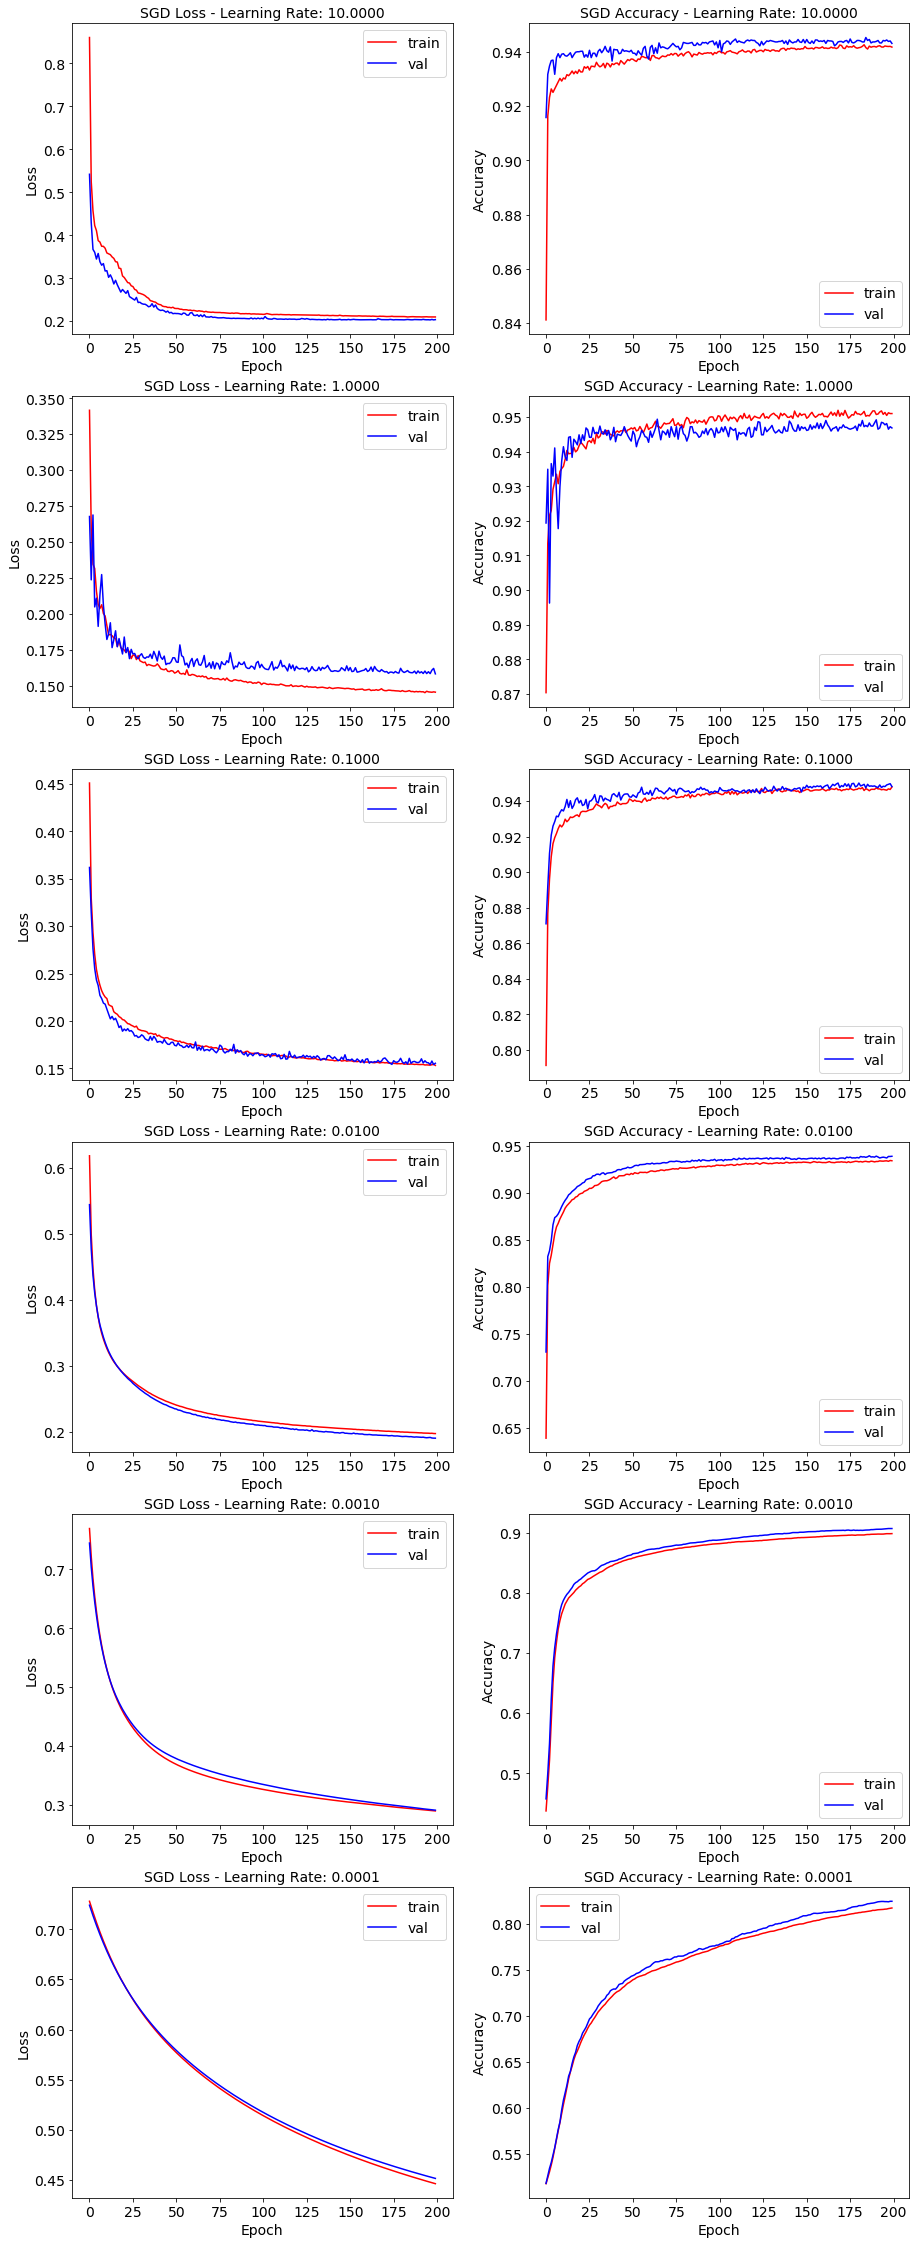

In [31]:
fig, ax = plt.subplots(len(learning_rate_list), 2, figsize=(15, 40))

for i in range(len(learning_rate_list)):
    ax[i][0].plot(sgd_results[i].history['loss'], 'r', label='train')
    ax[i][0].plot(sgd_results[i].history['val_loss'], 'b', label='val')
    ax[i][0].set_xlabel(r'Epoch', fontsize=14)
    ax[i][0].set_ylabel(r'Loss', fontsize=14)
    ax[i][0].set_title(r'SGD Loss - Learning Rate: %.4f' % learning_rate_list[i], fontsize=14)
    ax[i][0].legend(fontsize=14)
    ax[i][0].tick_params(labelsize=14)

    ax[i][1].plot(sgd_results[i].history['acc'], 'r', label='train')
    ax[i][1].plot(sgd_results[i].history['val_acc'], 'b' ,label='val')
    ax[i][1].set_xlabel(r'Epoch', fontsize=14)
    ax[i][1].set_ylabel(r'Accuracy', fontsize=14)
    ax[i][1].set_title(r'SGD Accuracy - Learning Rate: %.4f' % learning_rate_list[i], fontsize=14)
    ax[i][1].legend(fontsize=14)
    ax[i][1].tick_params(labelsize=14)


In [32]:
## Compare learning rates
sgd_loss_df = pd.DataFrame()
sgd_acc_df = pd.DataFrame()

for i in range(len(learning_rate_list)):
    sgd_loss_df[str(learning_rate_list[i])] = list(sgd_results[i].history['val_loss'])
    sgd_acc_df[str(learning_rate_list[i])] = list(sgd_results[i].history['val_acc'])

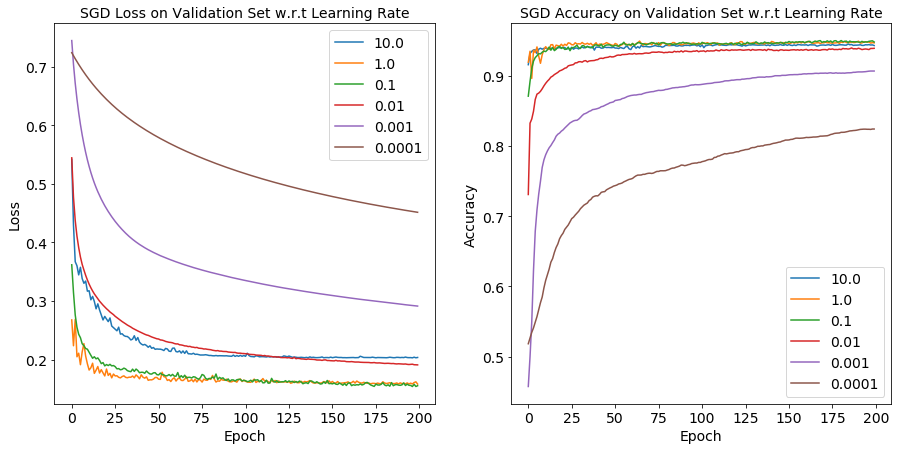

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

sgd_loss_df.plot(ax=ax[0])
ax[0].set_title(r'SGD Loss on Validation Set w.r.t Learning Rate', fontsize=14)
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].legend(fontsize=14, loc='upper right')
ax[0].tick_params(labelsize=14)

sgd_acc_df.plot(ax=ax[1])
ax[1].set_title(r'SGD Accuracy on Validation Set w.r.t Learning Rate', fontsize=14)
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].legend(fontsize=14, loc='best')
ax[1].tick_params(labelsize=14)

In [34]:
sgd_opt_lr = float(list(sgd_acc_df.idxmax(axis=1))[-1])
print("Learning rate of %.2f gives the highest accuracy for SGD optimizer." % sgd_opt_lr)

Learning rate of 0.10 gives the highest accuracy for SGD optimizer.


In [35]:
## hyperparameters
epochs = 200
learning_rate = sgd_opt_lr
decay_rate = learning_rate / epochs

## Momentum
momentum_list = [9e-1, 8e-1, 7e-1, 6e-1, 5e-1, 4e-1]

## results
sgd_results_mom = []

for momentum in momentum_list: 
    ## optimizer 
    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

    ## build the model
    input_dim = x_train.shape[1]

    lr_model = Sequential()
    lr_model.add(Dense(32, activation="relu", input_dim = input_dim)) 
    lr_model.add(Dense(2, activation="sigmoid"))

    ## compile the model
    lr_model.compile(loss='binary_crossentropy',
                     optimizer=sgd,
                     metrics=['acc'])

    ## fit the model
    batch_size = int(x_train.shape[0]/100)

    lr_model_history = lr_model.fit(x_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_split=.2,
                                    verbose=0)
    
    sgd_results_mom.append(lr_model_history)

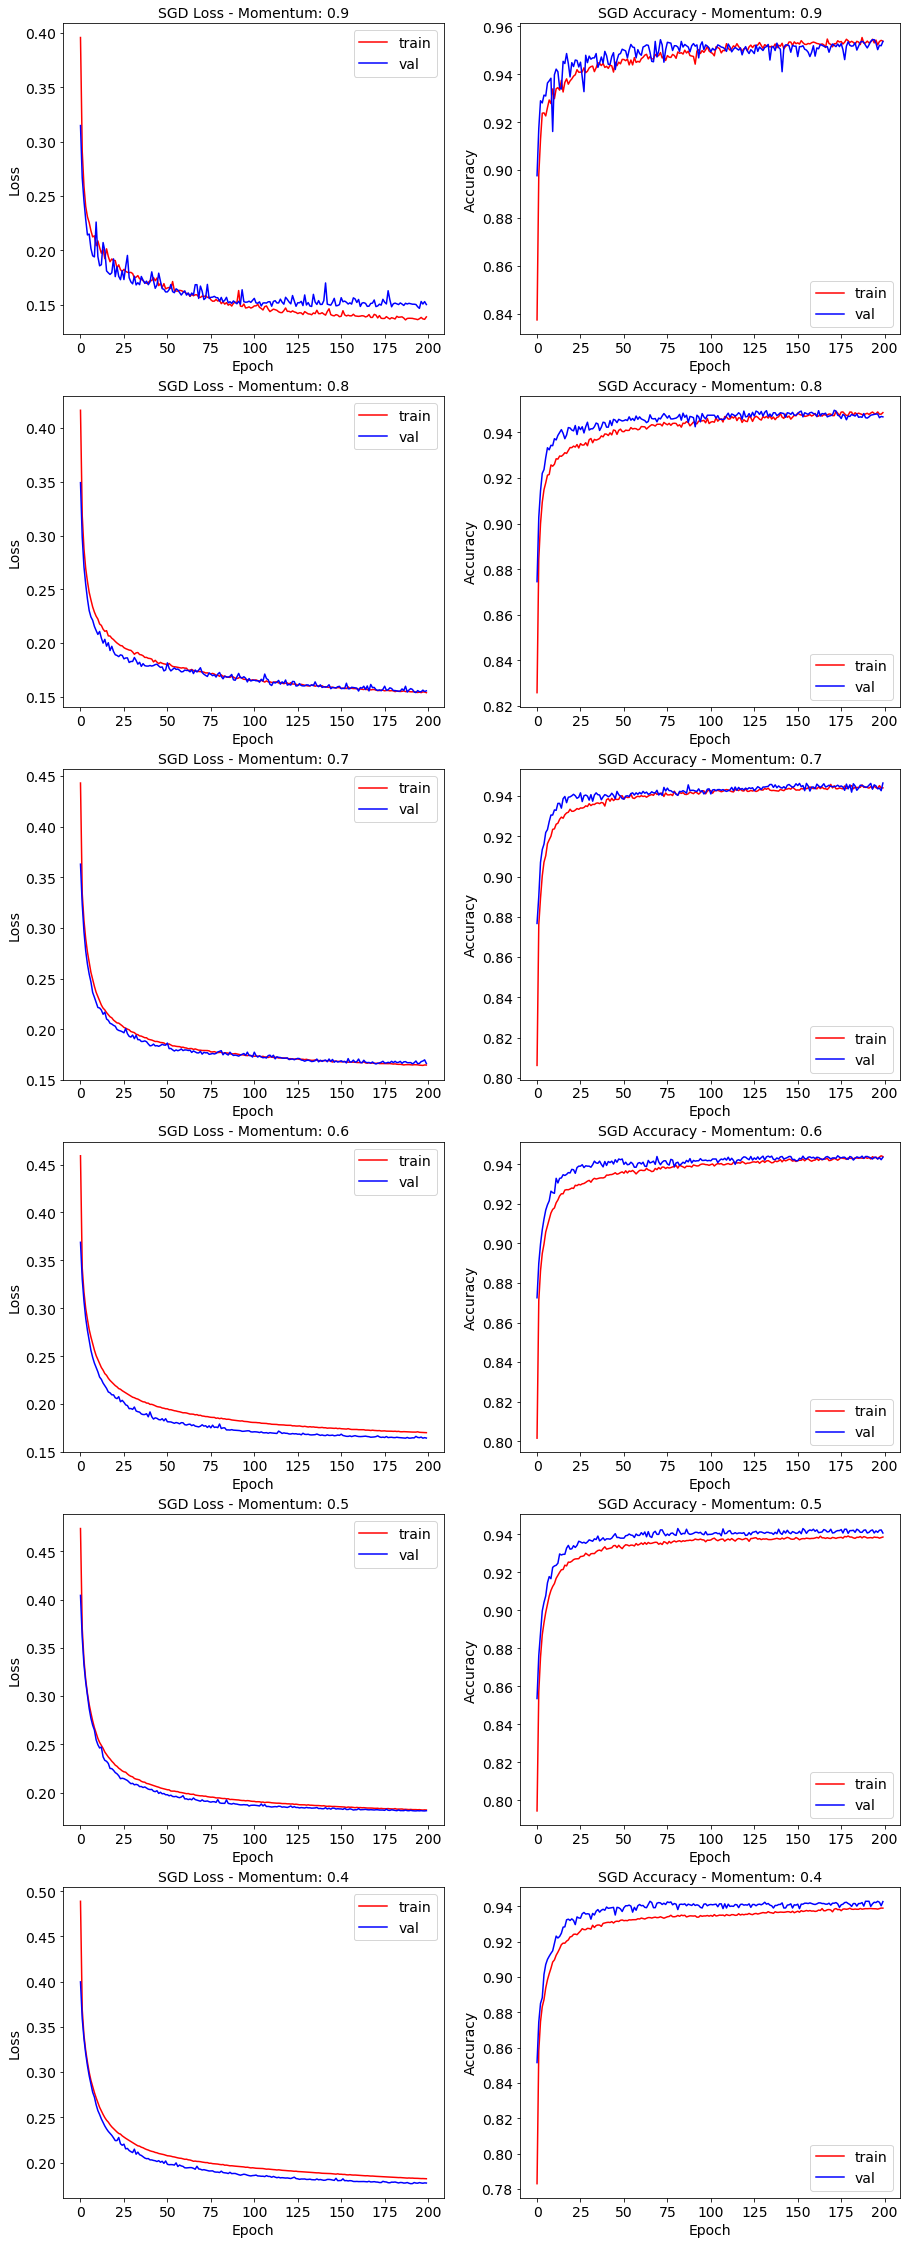

In [36]:
fig, ax = plt.subplots(len(momentum_list), 2, figsize=(15, 40))

for i in range(len(momentum_list)):
    ax[i][0].plot(sgd_results_mom[i].history['loss'], 'r', label='train')
    ax[i][0].plot(sgd_results_mom[i].history['val_loss'], 'b', label='val')
    ax[i][0].set_xlabel(r'Epoch', fontsize=14)
    ax[i][0].set_ylabel(r'Loss', fontsize=14)
    ax[i][0].set_title(r'SGD Loss - Momentum: %.1f' % momentum_list[i], fontsize=14)
    ax[i][0].legend(fontsize=14)
    ax[i][0].tick_params(labelsize=14)

    ax[i][1].plot(sgd_results_mom[i].history['acc'], 'r', label='train')
    ax[i][1].plot(sgd_results_mom[i].history['val_acc'], 'b' ,label='val')
    ax[i][1].set_xlabel(r'Epoch', fontsize=14)
    ax[i][1].set_ylabel(r'Accuracy', fontsize=14)
    ax[i][1].set_title(r'SGD Accuracy - Momentum: %.1f' % momentum_list[i], fontsize=14)
    ax[i][1].legend(fontsize=14)
    ax[i][1].tick_params(labelsize=14)


In [37]:
## Compare momentum
sgd_loss_df_mom = pd.DataFrame()
sgd_acc_df_mom = pd.DataFrame()

for i in range(len(learning_rate_list)):
    sgd_loss_df_mom[str(momentum_list[i])] = list(sgd_results_mom[i].history['val_loss'])
    sgd_acc_df_mom[str(momentum_list[i])] = list(sgd_results_mom[i].history['val_acc'])

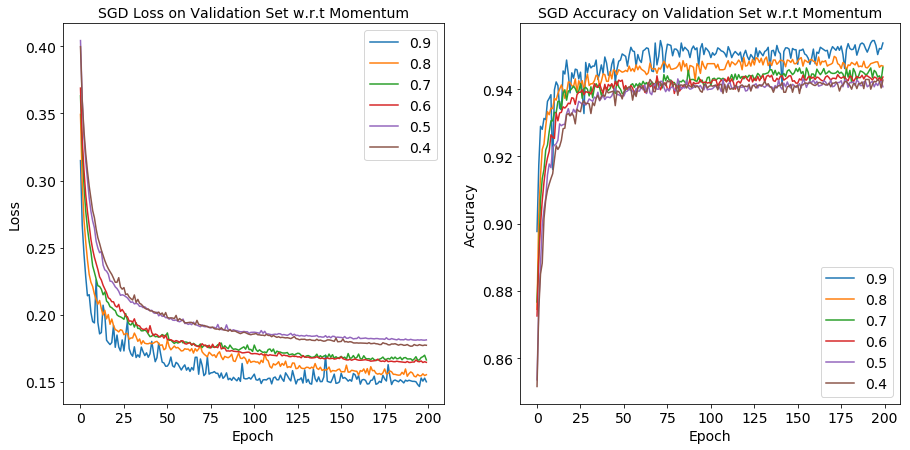

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

sgd_loss_df_mom.plot(ax=ax[0])
ax[0].set_title(r'SGD Loss on Validation Set w.r.t Momentum', fontsize=14)
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].legend(fontsize=14, loc='upper right')
ax[0].tick_params(labelsize=14)

sgd_acc_df_mom.plot(ax=ax[1])
ax[1].set_title(r'SGD Accuracy on Validation Set w.r.t Momentum', fontsize=14)
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].legend(fontsize=14, loc='best')
ax[1].tick_params(labelsize=14)

In [39]:
sgd_opt_mom = float(list(sgd_acc_df_mom.idxmax(axis=1))[-1])
print("Momentum of %.2f gives the highest accuracy for SGD optimizer." % sgd_opt_mom)

Momentum of 0.90 gives the highest accuracy for SGD optimizer.


<span class='sub-q'> 2.3 </span> Compare model training using Adam versus SGD:
- describe the difference between the behaviors of these two optimizers. 
- which optimizer gives the best model at the end of say 5000 epochs?

Which optimization method do you prefer for this data set? Why? 
Think of some scenarios where each optimizer might be more appropriate than the other.

In [40]:
#### Adam Final version 
## seed
seed(100)
set_random_seed(101)

## hyperparameters
epochs = 5000
learning_rate = adam_opt_lr
decay_rate = learning_rate / epochs

## optimizer 
adam = Adam(lr=learning_rate, decay=decay_rate)

## build the model
input_dim = x_train.shape[1]

adam_model = Sequential()
adam_model.add(Dense(32, activation="relu", input_dim = input_dim)) 
adam_model.add(Dense(2, activation="sigmoid"))

## compile the model
adam_model.compile(loss='binary_crossentropy',
                   optimizer=adam,
                   metrics=['acc'])

## fit the model
batch_size = int(x_train.shape[0]/100)

adam_final = adam_model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_split=.2,
                            verbose=0)

In [41]:
#### SGD Final version 
## seed
seed(100)
set_random_seed(101)

## hyperparameters
epochs = 5000
learning_rate = sgd_opt_lr
decay_rate = learning_rate / epochs
momentum = sgd_opt_mom

## optimizer 
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

## build the model
input_dim = x_train.shape[1]

sgd_model = Sequential()
sgd_model.add(Dense(32, activation="relu", input_dim = input_dim)) 
sgd_model.add(Dense(2, activation="sigmoid"))

## compile the model
sgd_model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['acc'])

## fit the model
batch_size = int(x_train.shape[0]/100)

sgd_final = sgd_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          validation_split=.2,
                          verbose=0)

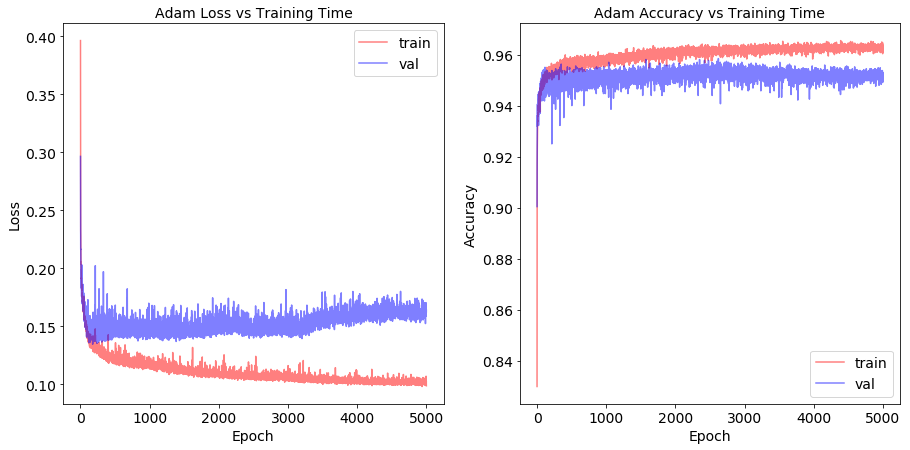

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].plot(adam_final.history['loss'], 'r', label='train', alpha=0.5)
ax[0].plot(adam_final.history['val_loss'], 'b' ,label='val', alpha=0.5)
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].set_title(r'Adam Loss vs Training Time', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(adam_final.history['acc'], 'r', label='train', alpha=0.5)
ax[1].plot(adam_final.history['val_acc'], 'b' ,label='val', alpha=0.5)
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].set_title(r'Adam Accuracy vs Training Time', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

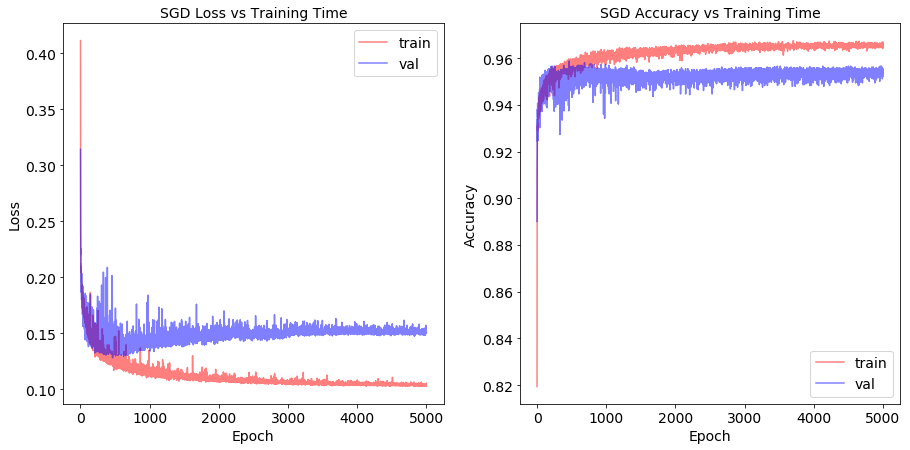

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].plot(sgd_final.history['loss'], 'r', label='train', alpha=0.5)
ax[0].plot(sgd_final.history['val_loss'], 'b' ,label='val', alpha=0.5)
ax[0].set_xlabel(r'Epoch', fontsize=14)
ax[0].set_ylabel(r'Loss', fontsize=14)
ax[0].set_title(r'SGD Loss vs Training Time', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(labelsize=14)

ax[1].plot(sgd_final.history['acc'], 'r', label='train', alpha=0.5)
ax[1].plot(sgd_final.history['val_acc'], 'b' ,label='val', alpha=0.5)
ax[1].set_xlabel(r'Epoch', fontsize=14)
ax[1].set_ylabel(r'Accuracy', fontsize=14)
ax[1].set_title(r'SGD Accuracy vs Training Time', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(labelsize=14)

In [59]:
## Compare model performance on test set 
adam_final_loss, adam_final_acc = adam_model.evaluate(x_test, y_test)
sgd_final_loss, sdg_final_acc = sgd_model.evaluate(x_test, y_test)

print("Adam final test set loss value: %.3f, accuracy: %.3f" % (adam_final_loss, adam_final_acc))
print("SGD final test set loss value: %.3f, accuracy: %.3f" % (sgd_final_loss, sdg_final_acc))

5928/5928 [==============================] - 0s 16us/step
Adam final test set loss value: 0.164, accuracy: 0.948
SGD final test set loss value: 0.149, accuracy: 0.950


Q: Describe the difference between the behaviors of these two optimizers.
- SGD converges really fast in few hundreds epochs, and the loss value and accuracy stays quite stable even with more training time, on both training set and validation set. 
- On the other hand, Adam converges slowly, which takes around 2000 epochs, and the loss and accuracy oscillate quite a bit as we train it longer, on both training set and validation set.  



Q: Which optimizer gives the best model at the end of say 5000 epochs?
- SGD gives the higher accuracy of 95.0% vs 94.8% of Adam on test set.  




Q: Which optimization method do you prefer for this data set? Why? 
- We prefere SGD for this data set. First of all, SGD gives the better model given the higher accuracy on test set. Second, SGD converges faster than Adam, which is computationally more efficient. Finally, validation loss and accuracy of SGD is more stable than Adam as we train the models longer.
- With all above being said, the validation set loss of SGD starts to become higher around epoch around 500, which is a sign of overfitting. Thus, it might be better to early stop in fitting SDG to get even better performance.  



Q: Think of some scenarios where each optimizer might be more appropriate than the other.
- SGD is fast and preferred in our data set. While if there is high curvature, SGD will oscillate and become slow because updates do not exploit curvature information. Adam, Adaptive Moment Estimation, will be faster, given that the average gradient may present a faster path.  

<div class='exercise'><b> Question 3: Generalizing Models for Galaxy Classification </b></div>

In this problem, you will revisit the task of classifying galaxies based on visual morphology. You will deploy the model you built in Question 1 on a new, much larger sky survey. In this new data set, which for now we will assume it represents the true Universe, only a small number of observations have been labeled. Your goal is to estimate the proportion of elliptical galaxies in the Universe.
<br><br>**Note** There are multiple *correct* answers to these questions. What we are looking for is a scientific approach to support your arguments with empirical evidences or first principles. 


In [45]:
universe_df = pd.read_csv('data/galaxy_morphology_semi_labeled.csv')
universe_df.head()

,green_color,red_color,infrared_color,de_vaucouleurs_fit_axial_ratio,exponential_fit_axial_ratio,exponential_disc_fit_log_likelihood,de_vaucouleurs_fit_log_likelihood,star_log_likelihood,number_of_votes,probability_elliptical,probability_spiral,probability_unknown,probability_merger,class
0,20.597660,19.763248,19.377018,0.890790,0.887719,-365.51312,-10296.39500,-69448.500,NaN,NaN,NaN,NaN,NaN,NaN
1,16.068602,14.275770,13.406208,0.846962,0.583541,-12756.09600,-32272.31200,-203823.920,NaN,NaN,NaN,NaN,NaN,NaN
2,25.601834,23.291614,24.511544,0.699872,0.749809,-86.31708,-227.30617,-1036.990,NaN,NaN,NaN,NaN,NaN,NaN
3,22.686954,20.837614,20.032396,0.705292,0.655978,-8858.64400,-1597.61410,-38869.620,NaN,NaN,NaN,NaN,NaN,NaN
4,20.464190,19.271786,18.617180,0.470536,0.424177,-1635.48885,-11248.65150,-83958.805,NaN,NaN,NaN,NaN,NaN,NaN


<span class='sub-q'> 3.1 </span> Use the model you built in Question 1 to estimate the proportion of ellipticall galaxies. Is this estimate trust worthy? Why or why not? 

In [46]:
## Feature Engineering
features = ["green_color", "red_color", "infrared_color", "de_vaucouleurs_fit_axial_ratio", 
            "exponential_fit_axial_ratio", "exponential_disc_fit_log_likelihood", 
            "de_vaucouleurs_fit_log_likelihood", "star_log_likelihood", "green_red_diff", "red_infrared_diff"]

universe_df['green_red_diff'] = universe_df.green_color - universe_df.red_color
universe_df['red_infrared_diff'] = universe_df.red_color - universe_df.infrared_color
universe_df[features] = (universe_df[features] - x_mean)/x_std

In [47]:
## Prediction 
y_pred = model2.predict(universe_df[features], batch_size=batch_size)
universe_df['predict'] = y_pred.argmax(axis=-1)

universe_label = universe_df[pd.notnull(universe_df['class'])]
universe_label['elliptical'] = 0
universe_label.loc[universe_label['class'] == 'elliptical', 'elliptical'] = 1

In [48]:
## Evaluation
universe_label_elliptical = np_utils.to_categorical(universe_label.elliptical, 2)
model_base_loss_31, model_base_acc_31 = model2.evaluate(universe_label[features], 
                                                        universe_label_elliptical, batch_size=batch_size)

print("Model new test set loss value: %.2f, accuracy: %.2f" % (model_base_loss_31, model_base_acc_31))

4702/4702 [==============================] - 0s 5us/step
Model new test set loss value: 7.94, accuracy: 0.48


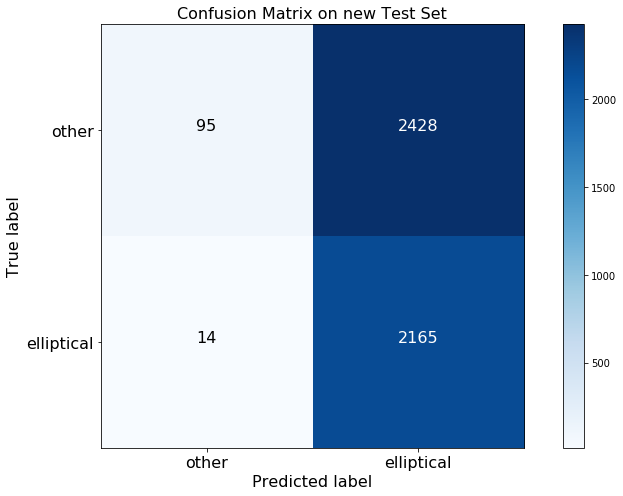

In [49]:
## Confusion Matrix
cnf_matrix = confusion_matrix(universe_label.elliptical, universe_label.predict)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["other", "elliptical"], normalize=False,
                      title='Confusion Matrix on new Test Set')

In [50]:
precision, recall, F1, _ = precision_recall_fscore_support(universe_label.elliptical, 
                                                           universe_label.predict, average='binary')

print("model precision: %.2f, recall: %.2f, F1: %.2f" % (precision, recall, F1))
print("Pecentage of elliptical in new test data: %.2f%%" % (100 * universe_label.elliptical.sum()/universe_label.shape[0]))
print("Pecentage of elliptical classified correctly: %.2f%%" % (100 * cnf_matrix[1][1]/np.sum(cnf_matrix[1])))
print("Pecentage of other classified correctly: %.2f%%" % (100 * cnf_matrix[0][0]/np.sum(cnf_matrix[0])))


model precision: 0.47, recall: 0.99, F1: 0.64
Pecentage of elliptical in new test data: 46.34%
Pecentage of elliptical classified correctly: 99.36%
Pecentage of other classified correctly: 3.77%


The model is not trust worthy, because for the ones with labels, it predicted every observation to be elliptical. Therefore, the F1 is only about 64% and the average accuracy is only about 48%.

<span class='sub-q'> 3.2 </span> The performance of classifier will perform differently on this new data set than it does on the data the model was trained (and tested on) in question 1. This is a common occurance in machine learning. Identify and eliminate at least one likely cause of this performance difference in the data. 

(***Hint:*** perform some exploratory data analysis on the new data and compare the features distributions of the data set in question 1 and of the data in this question)


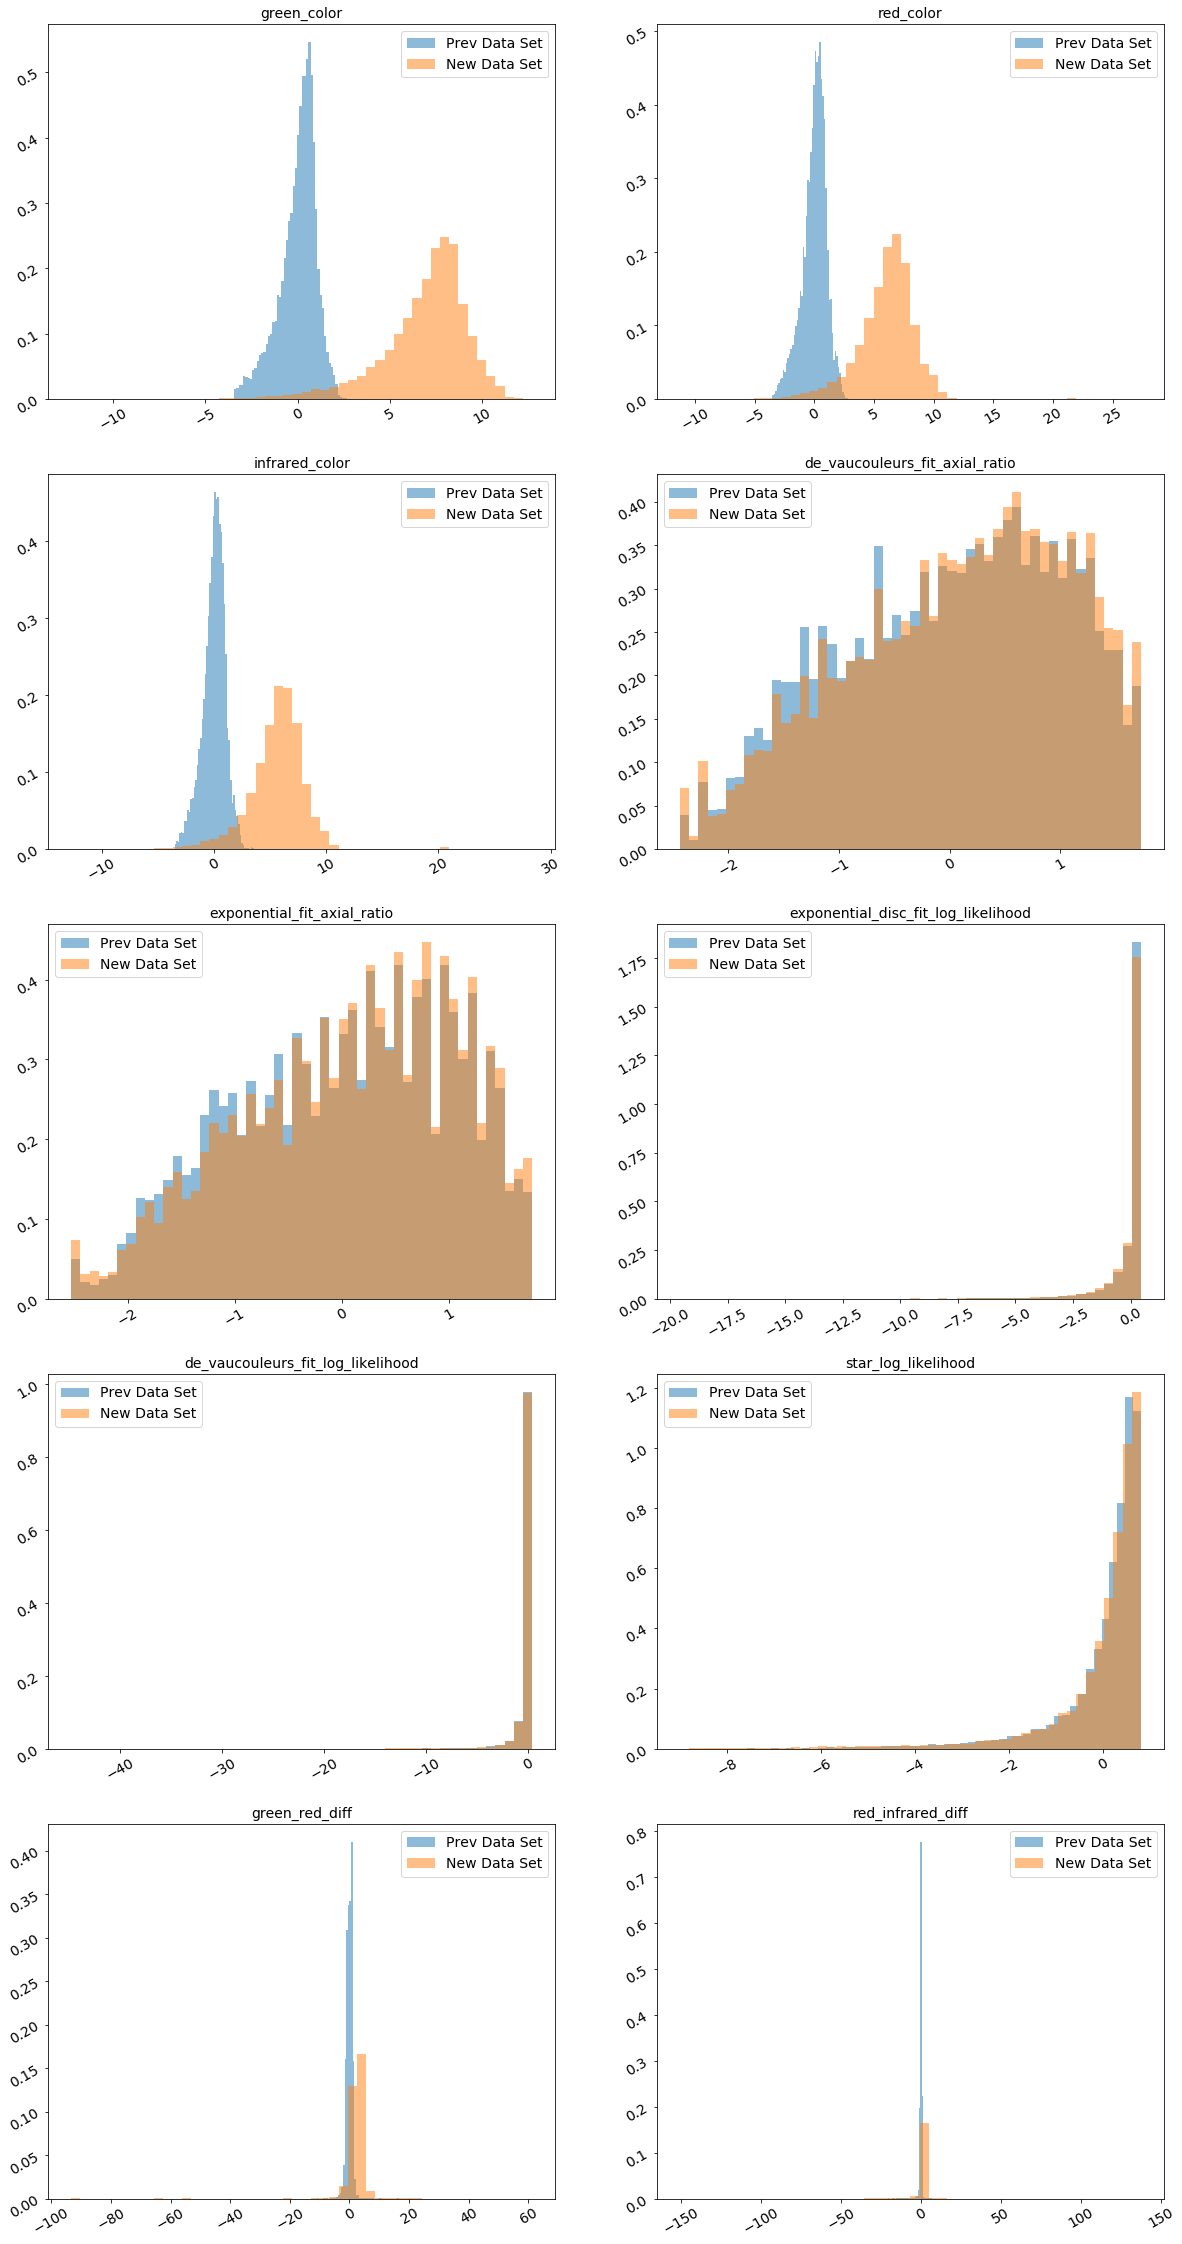

In [51]:
fig, axs = plt.subplots(5, 2, figsize=(20, 40))
axs = axs.ravel()

prev_dataset = pd.merge(x_train, x_test, how='outer')

for i in range(10):
    axs[i].hist(prev_dataset[features[i]], alpha=0.5, label='Prev Data Set', bins=50, density = True)
    axs[i].hist(universe_df[features[i]], alpha=0.5, label='New Data Set', bins=50, density = True)
    axs[i].legend(loc='best')
    axs[i].set_title(str(features[i]), fontsize=14)
    axs[i].tick_params(labelrotation=30)
    axs[i].legend(fontsize=14)
    axs[i].tick_params(labelsize=14)
    

After plotting the distributions of the features for the old and new data set, we find out the color band features from the new data set have very different distribution from the data set we used to train and test our model. The color band features distribution of the new data set has a much fatter tail and the mean is biased to the more positive tail. This is more consistent with what we see for elliptical class in 1.2.2 that the color features of the ellipitical class are more biased to the right side of the distribution.

In [52]:
def enhanced_model(x_train, y_train):
    ## hypyparameters
    epochs = 100
    learning_rate = 0.75
    decay_rate = learning_rate / epochs
    momentum = 0.8
    
    ## optimizer
    sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    
    ## build the model
    input_dim = x_train.shape[1]

    model = Sequential()
    model.add(Dense(64, activation="relu", input_dim = input_dim)) 
    model.add(Dense(64,  activation="relu"))
    model.add(Dense(2,  activation="sigmoid"))

    ## compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['acc'])

    batch_size = int(x_train.shape[0]/100)
    
    ## fit the model
    model_history = model.fit(x_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_split=.3,
                              verbose=0)
    
    return model

In [53]:
## Fit the model
features_list = ["de_vaucouleurs_fit_axial_ratio", 
                 "exponential_fit_axial_ratio", 
                 "exponential_disc_fit_log_likelihood", 
                 "de_vaucouleurs_fit_log_likelihood", 
                 "star_log_likelihood"]

model_new = enhanced_model(x_train[features_list], y_train)

In [54]:
## Prediction 
y_pred = model_new.predict(universe_df[features_list] , batch_size=batch_size)
universe_df['predict_new'] = y_pred.argmax(axis=-1)

universe_label = universe_df[pd.notnull(universe_df['class'])]
universe_label['elliptical'] = 0
universe_label.loc[universe_label['class'] == 'elliptical','elliptical'] = 1

In [55]:
## Evaluation
universe_label_elliptical = np_utils.to_categorical(universe_label.elliptical, 2)
model_base_loss_32, model_base_acc_32 = model_new.evaluate(universe_label[features_list], 
                                                           universe_label_elliptical, batch_size=batch_size)

print("Enhanced model new test set loss value: %.2f, accuracy: %.2f" % (model_base_loss_32, model_base_acc_32))

4702/4702 [==============================] - 0s 5us/step
Enhanced model new test set loss value: 0.44, accuracy: 0.78


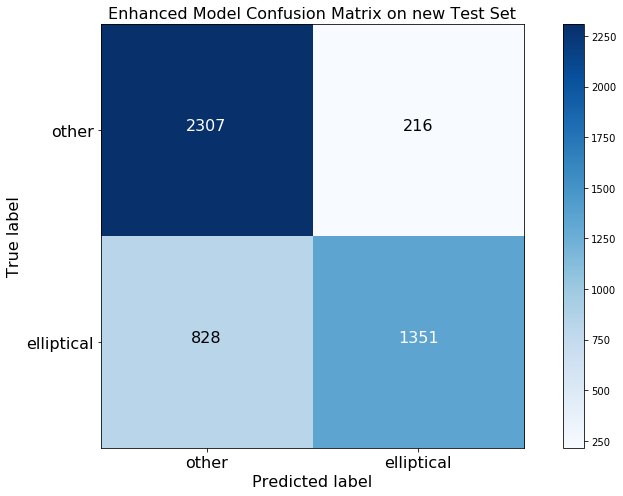

In [56]:
## Confusion Matrix
cnf_matrix = confusion_matrix(universe_label.elliptical, universe_label.predict_new)

plt.figure(figsize=(11,7))
plot_confusion_matrix(cnf_matrix, classes=["other", "elliptical"], normalize=False,
                      title='Enhanced Model Confusion Matrix on new Test Set')

In [57]:
precision, recall, F1, _ = precision_recall_fscore_support(universe_label.elliptical, 
                                                           universe_label.predict_new, average='binary')

print("Enhanced Model - model precision: %.2f, recall: %.2f, F1: %.2f" % (precision, recall, F1))
print("Enhanced Model - Pecentage of elliptical in new test data: %.2f%%" % (100 * universe_label.elliptical.sum()/universe_label.shape[0]))
print("Enhanced Model - Pecentage of elliptical classified correctly: %.2f%%" % (100 * cnf_matrix[1][1]/np.sum(cnf_matrix[1])))
print("Enhanced Model - Pecentage of other classified correctly: %.2f%%" % (100 * cnf_matrix[0][0]/np.sum(cnf_matrix[0])))


Enhanced Model - model precision: 0.86, recall: 0.62, F1: 0.72
Enhanced Model - Pecentage of elliptical in new test data: 46.34%
Enhanced Model - Pecentage of elliptical classified correctly: 62.00%
Enhanced Model - Pecentage of other classified correctly: 91.44%


By removing those color band features, we are able to improve F1 from 64% to 72%, and average accuracy from 48% to 78%.

<span class='sub-q'> 3.3 (Implementation not required) </span>  Based on your observations, propose a method to produce an accurate estimate of the proportion of elliptical galaxies in the new data set, support your proposal with results from data analysis and concepts from data science. 

In [58]:
universe_df.predict_new.value_counts(normalize=True)

0    0.669155
1    0.330845
Name: predict_new, dtype: float64

Based on our revised model, we predicte that ~33% of the universe are the elliptical galaxies.

Our answer to the previous question is essentially our method and proposal to get a better estimate. 

The key element of the method is to compare the feature distribution in the test set vs the feature distribution in the training set. If the two distributions of some features are very different, we should consider dropping those features from the feature space, and re-train the model with the remaining features. In this question, we decide to drop the color features, because the distribution are so different vs the ones in the training set. We make the decision by just visual inspection here, but certainly we can make it more scientific by leveraging statistical measures like Kullback–Leibler divergence and Wasserstein distance to measure the distance between two empirical distributions. We can setup some threshold of these measures, and decide to drop the features based on it.

This method/concept makes a lot sense to us, especially as data scientists in the financial industry. Since we are not  astronomy experts, we will just use financial market as examples. The stock market changes with the economy cycle, which typically takes around 8 to 12 years. The features/indicators that are predictive in one market regime might be useless in another market regime. It is not uncommon to drop old features and come up with new features to predict the stock market. 

Another point that we want to make is that we measure our model performance based on F1, which balances precision and recall ratios. Even though the base model achives 99% recall, the precision is very low. It means that model is predicting every observation to be ellpitical, but we don't need a model whose prediction is alwasy the same. F1 balances false positive and false negative observations, and we believe it's a better measure. 

